# Examining vaccination rates

The [Western Pennsylvania Regional Data Center](https://www.wprdc.org) collects, timestamps, and archives Pennsylvania's [public vaccination data](https://data.pa.gov/browse?q=vaccinations) as it updates. These [archived datasets](https://data.wprdc.org/dataset/weekly-pennsylvania-covid-19-vaccinations-stats-archive) allow for examination of vaccination rates over time.

## Zip code

### Get the data

In [73]:
import pandas
import pandas as pd

vac_race_zip_csv = "https://data.wprdc.org/datastore/dump/d3f5c6a6-c5f8-48db-8da2-f22a39bc8ef8"


def n2z(x) -> float:
    return float(0) if not x else float(x)


# converts null to 0 on the data fields
converters = {k: n2z for k in range(2, 16)}

df = pandas.read_csv(
    vac_race_zip_csv,
    parse_dates=['date_saved'],
    converters=converters,
    usecols=lambda c: c not in ['latitude', 'longitude', 'date_updated'],
    dtype={'patient_zip_code': str}
)
df.head()

,patient_zip_code,partially_covered_african_american,partially_covered_asian,partially_covered_native_american,partially_covered_pacific_islander,partially_covered_multiple_other,partially_covered_white,partially_covered_unknown,fully_covered_african_american,fully_covered_asian,fully_covered_native_american,fully_covered_pacific_islander,fully_covered_multiple_other,fully_covered_white,fully_covered_unknown,date_saved
0,17142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-07-27
1,15000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-07-27
2,19424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,2021-07-27
3,15448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,0.0,2021-07-27
4,15426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-07-27


### Mix-in demographic data

In [74]:
# Get zip_code demographic data and prepare to merge with vaccine data
demog_data_file = 'https://raw.githubusercontent.com/WPRDC/bec-vaccination-map/main/zip_code_pop_2019.csv'

source_demog_df = pd.read_csv(demog_data_file, dtype={'zip code tabulation area': str})

total_pop = source_demog_df['B01001_001E']
black_pop = source_demog_df['B01001B_001E']

# < 10 years populations
total_kid_pop = (source_demog_df['B01001_003E'] + source_demog_df['B01001_004E'] + source_demog_df['B01001_027E'] +
                 source_demog_df['B01001_028E'])

black_kid_pop = (source_demog_df['B01001B_003E'] + source_demog_df['B01001B_004E'] + source_demog_df['B01001B_018E'] +
                 source_demog_df['B01001B_019E'])

eligible_pop = total_pop - total_kid_pop.multiply(1.2)
eligible_black_pop = black_pop - black_kid_pop.multiply(1.2)

demog_df = pd.DataFrame({
    'zip_code': source_demog_df['zip code tabulation area'],
    'eligible_pop': eligible_pop,
    'eligible_black_pop': eligible_black_pop,
})
demog_df.head()

,zip_code,eligible_pop,eligible_black_pop
0,15320,4545.6,0.0
1,15321,1363.8,0.0
2,15325,322.2,0.0
3,15334,107.4,0.0
4,15348,213.0,0.0


In [88]:
# Join datasets

race_strings = ['african_american', 'asian', 'multiple_other', 'native_american', 'pacific_islander', 'white',
                'unknown']

# join the demographic data with the vax data
full_df = pd.merge(df, demog_df, left_on='patient_zip_code', right_on='zip_code')

# get total vaccine numbers
full_df['fully_covered_total'] = sum([full_df[f'fully_covered_{race_str}'] for race_str in race_strings])
full_df['fully_covered_total_known'] = sum(
    [full_df[f'fully_covered_{race_str}'] for race_str in race_strings if race_str != 'unknown'])

# calculate the percents
full_df['total_percent_fully_covered'] = full_df['fully_covered_total'] / full_df['eligible_pop']
full_df['total_known_percent_fully_covered'] = full_df['fully_covered_total_known'] / full_df['eligible_pop']
full_df['black_percent_full_covered'] = full_df['fully_covered_african_american'] / full_df['eligible_black_pop']

full_df.head()

,patient_zip_code,partially_covered_african_american,partially_covered_asian,partially_covered_native_american,partially_covered_pacific_islander,partially_covered_multiple_other,partially_covered_white,partially_covered_unknown,fully_covered_african_american,fully_covered_asian,...,fully_covered_unknown,date_saved,zip_code,eligible_pop,eligible_black_pop,fully_covered_total,fully_covered_total_known,total_percent_fully_covered,total_known_percent_fully_covered,black_percent_full_covered
0,15448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2021-07-27,15448,284.8,0.0,38.0,38.0,0.133427,0.133427,NaN
1,15448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2021-08-02,15448,284.8,0.0,38.0,38.0,0.133427,0.133427,NaN
2,15448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2021-08-09,15448,284.8,0.0,38.0,38.0,0.133427,0.133427,NaN
3,15448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2021-08-16,15448,284.8,0.0,38.0,38.0,0.133427,0.133427,NaN
4,15448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2021-08-23,15448,284.8,0.0,38.0,38.0,0.133427,0.133427,NaN


### Percent of eligible Black residents who are fully vaccinated per zip code
For zip codes `15104`, `15132`, `15206`, `15208`, `15210`, `15212`, `15214`, `15219`, `15221`, `15235`

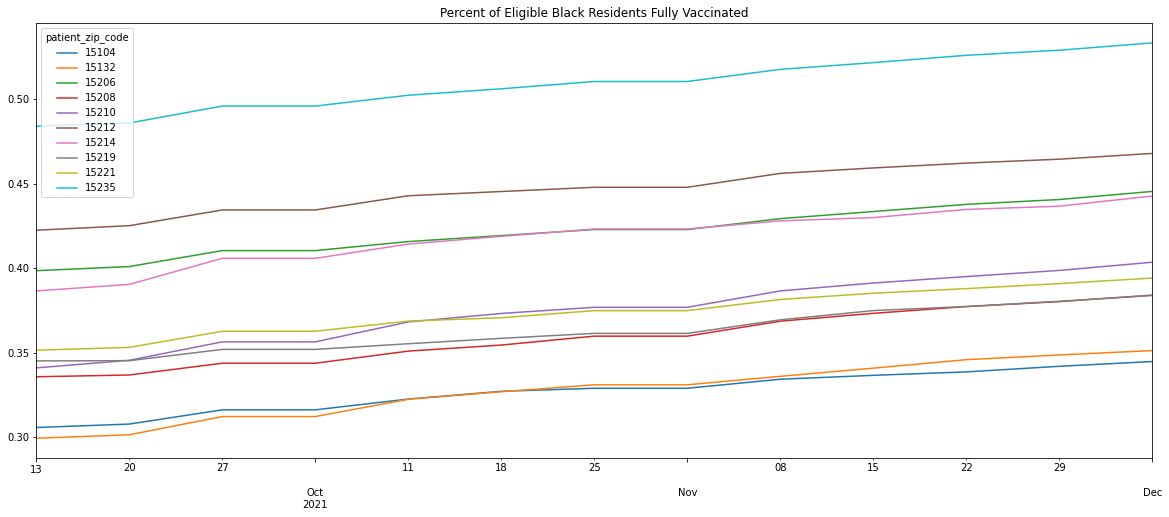

In [76]:
# Limit the dataset to the past month and select zipcodes
from datetime import datetime, timedelta, date

# start date being 30 days before today
start = datetime.now() - timedelta(days=90)

# filter for zipcodes that start '15'
local_zipcodes = lambda z: z[:2] == '15'

# filter zipcodes in Allegheny County with large proportion Black population
ac_black_zipcodes = ['15104', '15132', '15206', '15208', '15210', '15212', '15214', '15219', '15221', '15235', ]
full_df = full_df[(full_df['zip_code'].isin(ac_black_zipcodes)) & (full_df['date_saved'] > start)]

by_date_zip_pivot = full_df.pivot(index='date_saved', columns='patient_zip_code', values='black_percent_full_covered')
rate_plot = by_date_zip_pivot.plot(
    title='Percent of Eligible Black Residents Fully Vaccinated',
    xlabel='',
    figsize=(20, 8),
)

## Allegheny County
### Get the data

In [86]:
# get county data for comparison
county_csv = 'https://data.wprdc.org/datastore/dump/7272bc6b-7c7e-4a7f-9ec0-9ee034e6147e'
county_by_race_csv = 'https://data.wprdc.org/datastore/dump/a6f52fb9-6c3a-40e4-adc4-2bd806b165fd'

county_df = pd.read_csv(
    county_by_race_csv,
    parse_dates=['date_saved'],
    converters=converters,
    usecols=lambda c: c not in ['latitude', 'longitude', 'date_updated'],
)

# calculate totals
county_df['fully_covered_total'] = sum([county_df[f'fully_covered_{race_str}'] for race_str in race_strings])
county_df['fully_covered_total_known'] = sum(
    [county_df[f'fully_covered_{race_str}'] for race_str in race_strings if race_str != 'unknown'])

county_df['partially_covered_total'] = sum([county_df[f'partially_covered_{race_str}'] for race_str in race_strings])
county_df['partially_covered_total_known'] = sum(
    [county_df[f'partially_covered_{race_str}'] for race_str in race_strings if race_str != 'unknown'])

# limit to allegheny county
county_df = county_df[(county_df['county_name'].str.upper() == 'ALLEGHENY')]
county_df.sort_index(ascending=False).head()

,date_saved,county_name,partially_covered_african_american,partially_covered_asian,partially_covered_native_american,partially_covered_pacific_islander,partially_covered_multiple_other,partially_covered_white,partially_covered_unknown,fully_covered_african_american,fully_covered_asian,fully_covered_native_american,fully_covered_pacific_islander,fully_covered_multiple_other,fully_covered_white,fully_covered_unknown,fully_covered_total,fully_covered_total_known,partially_covered_total,partially_covered_total_known
2467,2021-12-06,ALLEGHENY,11323.0,4654.0,272.0,198.0,16954.0,76486.0,10283.0,59313.0,13104.0,626.0,2390.0,95361.0,521067.0,64868.0,756729.0,691861.0,120170.0,109887.0
2417,2021-11-29,ALLEGHENY,10741.0,4374.0,249.0,199.0,16037.0,74389.0,9950.0,58713.0,12689.0,614.0,2385.0,93825.0,516021.0,64952.0,749199.0,684247.0,115939.0,105989.0
2355,2021-11-22,ALLEGHENY,9849.0,3383.0,207.0,195.0,14440.0,65361.0,9393.0,58354.0,12424.0,607.0,2382.0,92434.0,514595.0,65252.0,746048.0,680796.0,102828.0,93435.0
2302,2021-11-15,ALLEGHENY,9239.0,2789.0,188.0,184.0,13352.0,56677.0,8708.0,57818.0,12178.0,593.0,2389.0,90162.0,512714.0,65684.0,741538.0,675854.0,91137.0,82429.0
2211,2021-11-08,ALLEGHENY,8740.0,2254.0,169.0,175.0,11332.0,48035.0,8894.0,57196.0,11914.0,578.0,2390.0,87819.0,510601.0,66951.0,737449.0,670498.0,79599.0,70705.0


### Mix-in county-level demographic data

In [87]:
import numpy as np
county_demog_df = pd.read_csv('https://github.com/WPRDC/bec-vaccination-map/raw/main/notebooks/ac_age_race.tsv', sep='\t')
ac_age_race_lookup = county_demog_df.to_dict('records')[0]
# Demographic data from from ACS 2019 (5yr agg)
county_total_pop = ac_age_race_lookup['B01001001']  # 1221744
county_black_pop = ac_age_race_lookup['B01001B001']  # 157060

total_lt_12_tables = ['B01001003', 'B01001004', 'B01001027', 'B01001028']
total_lt_5_tables = ['B01001003']

black_lt_12_tables = ['B01001B003', 'B01001B004', 'B01001B027', 'B01001B028']
black_lt_5_tables = ['B01001B003', ]

# acs categories don't break at 12 so we have to get the < 10y/o pop and multiply by 1.2
ac_total_lt_12_pop = sum([ac_age_race_lookup[table] for table in total_lt_12_tables]) * 1.2
ac_total_lt_5_pop = sum([ac_age_race_lookup[table] for table in total_lt_5_tables])

# acs categories don't break at 12 so we have to get the < 10y/o pop and multiply by 1.2
ac_black_lt_12_pop = sum([ac_age_race_lookup[table] for table in black_lt_12_tables]) * 1.2
ac_black_lt_5_pop = sum([ac_age_race_lookup[table] for table in black_lt_5_tables])

# eligible populations before FDA auth for < 5 year olds
ac_old_eligible_total_pop = county_total_pop - ac_total_lt_12_pop
ac_old_eligible_black_pop = county_black_pop - ac_black_lt_12_pop

# eligible populations on 2021-12-10
ac_cur_eligible_total_pop = county_total_pop - ac_total_lt_5_pop
ac_cur_eligible_black_pop = county_black_pop - ac_black_lt_5_pop

lt_5_auth_date = datetime.fromisoformat('2021-10-29')

county_df.set_index('date_saved')

# calculate rates from before
county_df['fully_covered_%_total_old'] = county_df['fully_covered_total'].divide(ac_old_eligible_total_pop)
county_df['fully_covered_%_african_american_old'] = county_df['fully_covered_african_american'].divide(
    ac_old_eligible_black_pop)
county_df['partially_covered_%_total_old'] = county_df['partially_covered_total'].divide(ac_old_eligible_total_pop)
county_df['partially_covered_%_total_known_old'] = county_df['partially_covered_total_known'].divide(
    ac_old_eligible_total_pop)
county_df['partially_covered_%_african_american_old'] = county_df['partially_covered_african_american'].divide(
    ac_old_eligible_black_pop)

# calculate current rates
county_df['fully_covered_%_total_cur'] = county_df['fully_covered_total'].divide(ac_cur_eligible_total_pop)
county_df['fully_covered_%_african_american_cur'] = county_df['fully_covered_african_american'].divide(
    ac_cur_eligible_black_pop)

county_df['partially_covered_%_total_cur'] = county_df['partially_covered_total'].divide(ac_cur_eligible_total_pop)
county_df['partially_covered_%_african_american_cur'] = county_df['partially_covered_african_american'].divide(
    ac_cur_eligible_black_pop)

# Join into one column based on date
county_df['fully_covered_%_total_both'] = np.where(
    county_df.date_saved >= lt_5_auth_date,
    county_df['fully_covered_%_total_cur'] * 100,
    county_df['fully_covered_%_total_old'] * 100
)
county_df['fully_covered_%_african_american_both'] = np.where(
    county_df.date_saved >= lt_5_auth_date,
    county_df['fully_covered_%_african_american_cur'] * 100,
    county_df['fully_covered_%_african_american_old'] * 100
)
county_df['partially_covered_%_total_both'] = np.where(
    county_df.date_saved >= lt_5_auth_date,
    county_df['partially_covered_%_total_cur'] * 100,
    county_df['partially_covered_%_total_old'] * 100
)
county_df['partially_covered_%_african_american_both'] = np.where(
    county_df.date_saved >= lt_5_auth_date,
    county_df['partially_covered_%_african_american_cur'] * 100,
    county_df['partially_covered_%_african_american_old'] * 100
)

county_df.sort_index(ascending=False).head()

,date_saved,county_name,partially_covered_african_american,partially_covered_asian,partially_covered_native_american,partially_covered_pacific_islander,partially_covered_multiple_other,partially_covered_white,partially_covered_unknown,fully_covered_african_american,...,partially_covered_%_total_known_old,partially_covered_%_african_american_old,fully_covered_%_total_cur,fully_covered_%_african_american_cur,partially_covered_%_total_cur,partially_covered_%_african_american_cur,fully_covered_%_total_both,fully_covered_%_african_american_both,partially_covered_%_total_both,partially_covered_%_african_american_both
2467,2021-12-06,ALLEGHENY,11323.0,4654.0,272.0,198.0,16954.0,76486.0,10283.0,59313.0,...,0.102602,0.094972,0.636423,0.391577,0.101065,0.074753,63.642335,39.157732,10.106523,7.475309
2417,2021-11-29,ALLEGHENY,10741.0,4374.0,249.0,199.0,16037.0,74389.0,9950.0,58713.0,...,0.098962,0.090091,0.630090,0.387616,0.097507,0.070911,63.009048,38.761619,9.750688,7.091080
2355,2021-11-22,ALLEGHENY,9849.0,3383.0,207.0,195.0,14440.0,65361.0,9393.0,58354.0,...,0.087241,0.082609,0.627440,0.385246,0.086480,0.065022,62.744043,38.524612,8.648029,6.502192
2302,2021-11-15,ALLEGHENY,9239.0,2789.0,188.0,184.0,13352.0,56677.0,8708.0,57818.0,...,0.076964,0.077493,0.623647,0.381708,0.076648,0.060995,62.364743,38.170751,7.664793,6.099477
2211,2021-11-08,ALLEGHENY,8740.0,2254.0,169.0,175.0,11332.0,48035.0,8894.0,57196.0,...,0.066018,0.073307,0.620209,0.377601,0.066944,0.057700,62.020851,37.760114,6.694426,5.770043


## Current Rates in Allegheny County


In [80]:
print('Fully:')
print('','Total: ', f"{county_df.sort_index(ascending=False).iloc[0]['fully_covered_%_total_cur'] * 100:2.0f}%")
print('','Black: ', f"{county_df.sort_index(ascending=False).iloc[0]['fully_covered_%_african_american_cur'] * 100:2.0f}%")
print('Partially:')
print('','Total: ', f"{county_df.sort_index(ascending=False).iloc[0]['partially_covered_%_total_cur'] * 100:2.0f}%")
print('','Black: ', f"{county_df.sort_index(ascending=False).iloc[0]['partially_covered_%_african_american_cur'] * 100:2.0f}%")

Fully:
 Total:  64%
 Black:  39%
Partially:
 Total:  10%
 Black:   7%


(0.0, 71.37629624987537)

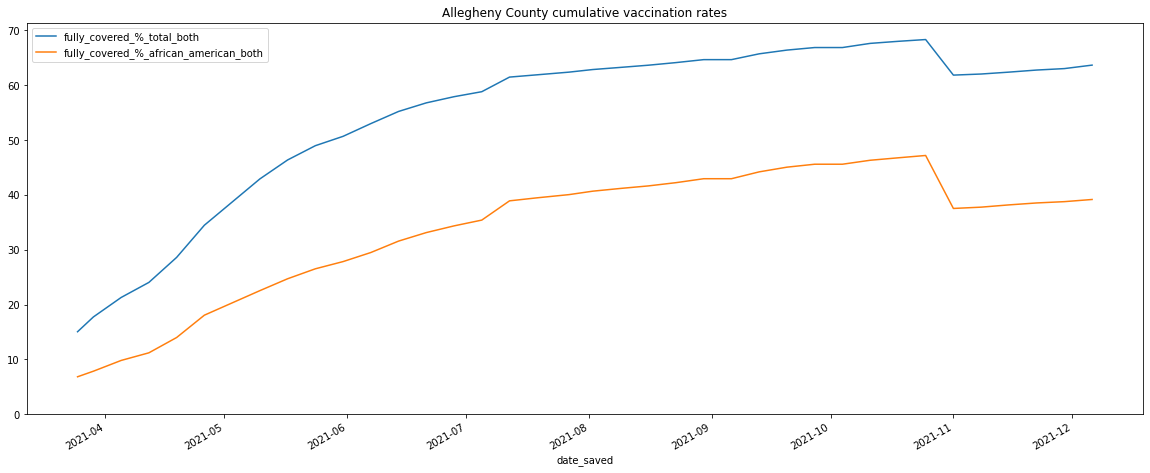

In [81]:
chart = county_df.plot(
    title='Allegheny County cumulative vaccination rates',
    figsize=(20, 8),
    x='date_saved',
    y=['fully_covered_%_total_both', 'fully_covered_%_african_american_both']
)
chart.set_ylim(bottom=0)

(0.0, 22.50541840851655)

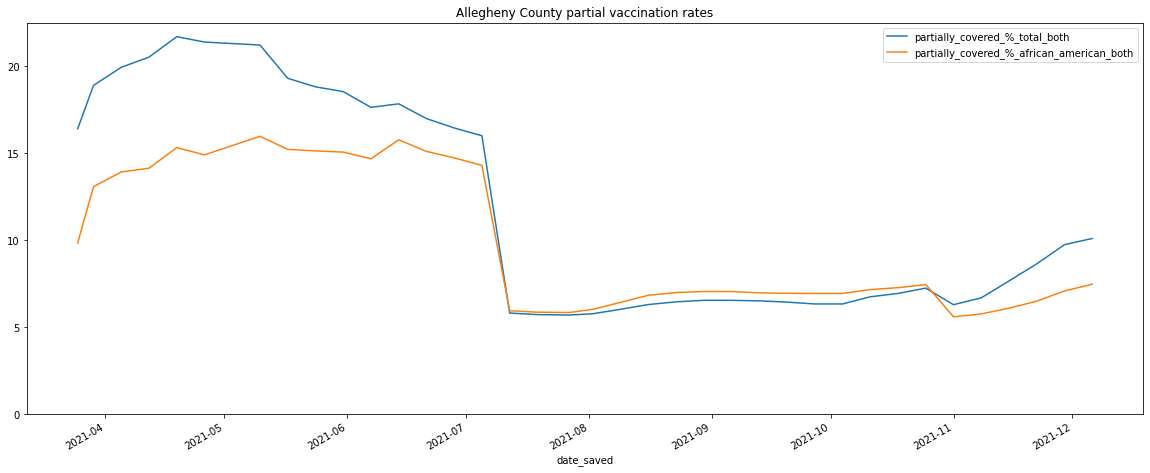

In [82]:
chart = county_df.plot(
    title='Allegheny County partial vaccination rates',
    figsize=(20, 8),
    x='date_saved',
    y=['partially_covered_%_total_both', 'partially_covered_%_african_american_both']
)
chart.set_ylim(bottom=0)

<AxesSubplot:title={'center':'Allegheny County partial vaccination rates (past 90 days)'}, xlabel='date_saved'>

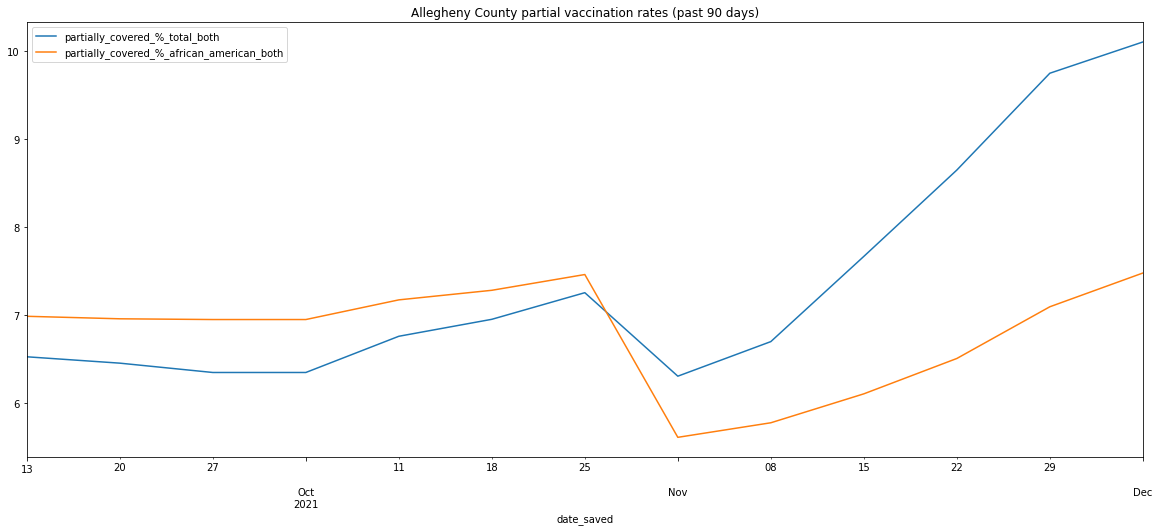

In [83]:
plot_start = datetime.now() - timedelta(days=90)
county_df[county_df['date_saved'] > plot_start].plot(
    title='Allegheny County partial vaccination rates (past 90 days)',
    figsize=(20, 8),
    x='date_saved',
    y=['partially_covered_%_total_both', 'partially_covered_%_african_american_both'],
)